In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=True, samp_freq=samp_freq)

In [5]:
# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = True, samp_freq=30_000)

In [6]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [7]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


visualize data

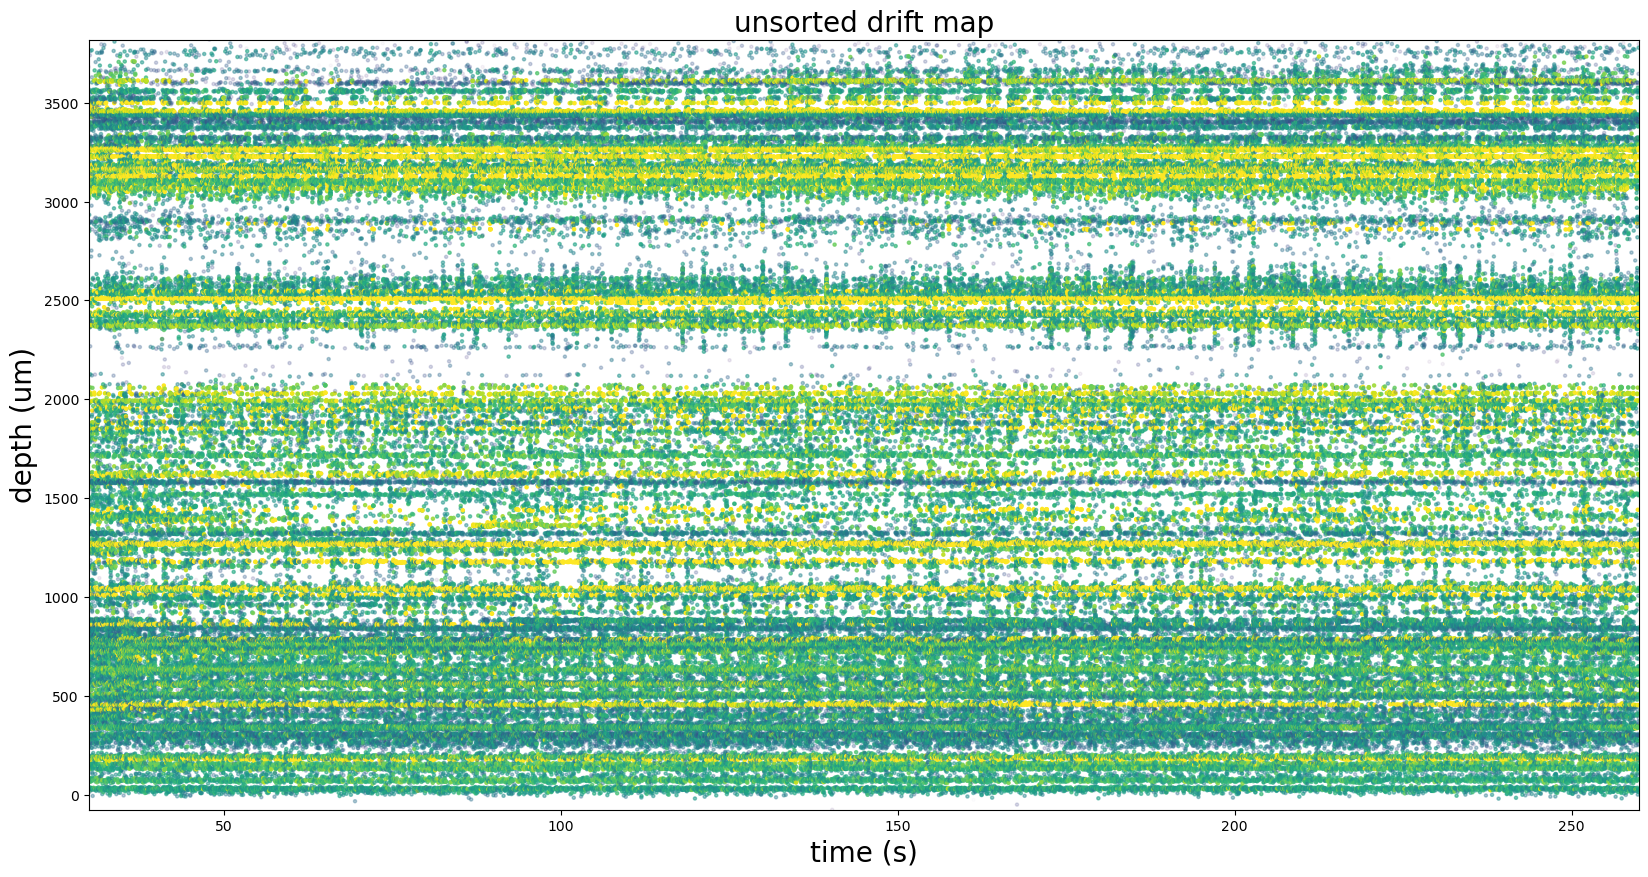

In [8]:
viz_tools.plot_drift_map(spikes_indices, spikes_features, n_spikes_display=300_000, samp_freq=samp_freq)

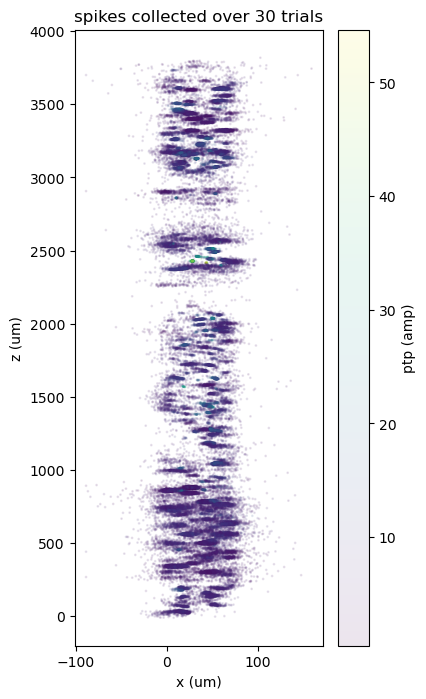

In [9]:
viz_tools.plot_spikes_features(trials, np.arange(100, 130))

initialize gmm using 5 mins' spike sorting results

In [8]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [9]:
initial_gmm = init_gmm.initialize_gaussian_mixtures_with_spike_sorting(rootpath, sub_id, trials, seed=666, fit_model=False)

In [10]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

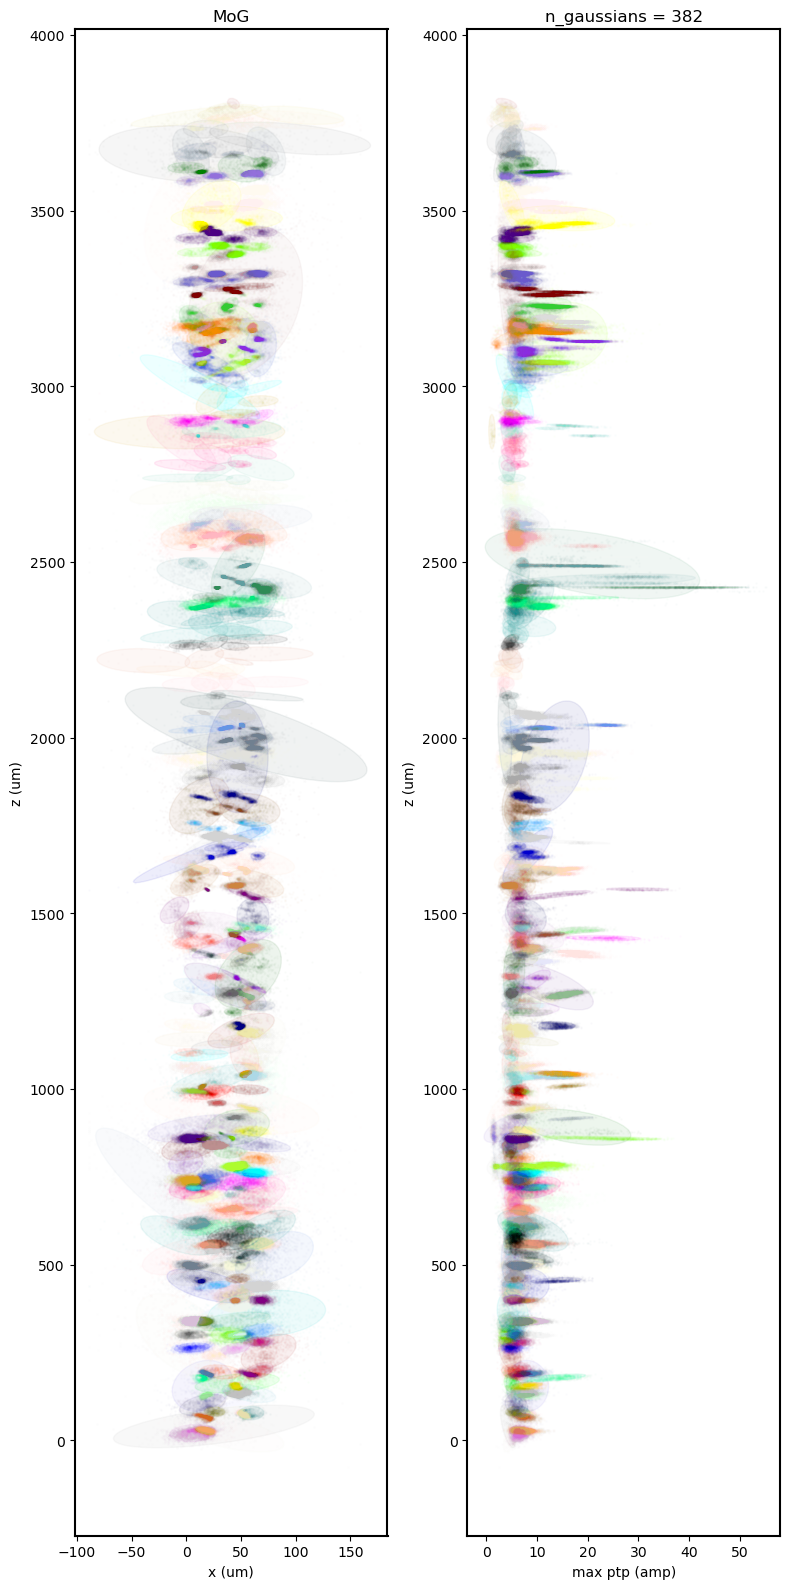

In [11]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, initial_labels, display_all_spikes=True, n_spikes_display=1_000)

In [11]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 382, 30)
clusterless neural projections shape: (230, 382, 15)
clusterless neural reconstructions shape: (230, 382, 30)


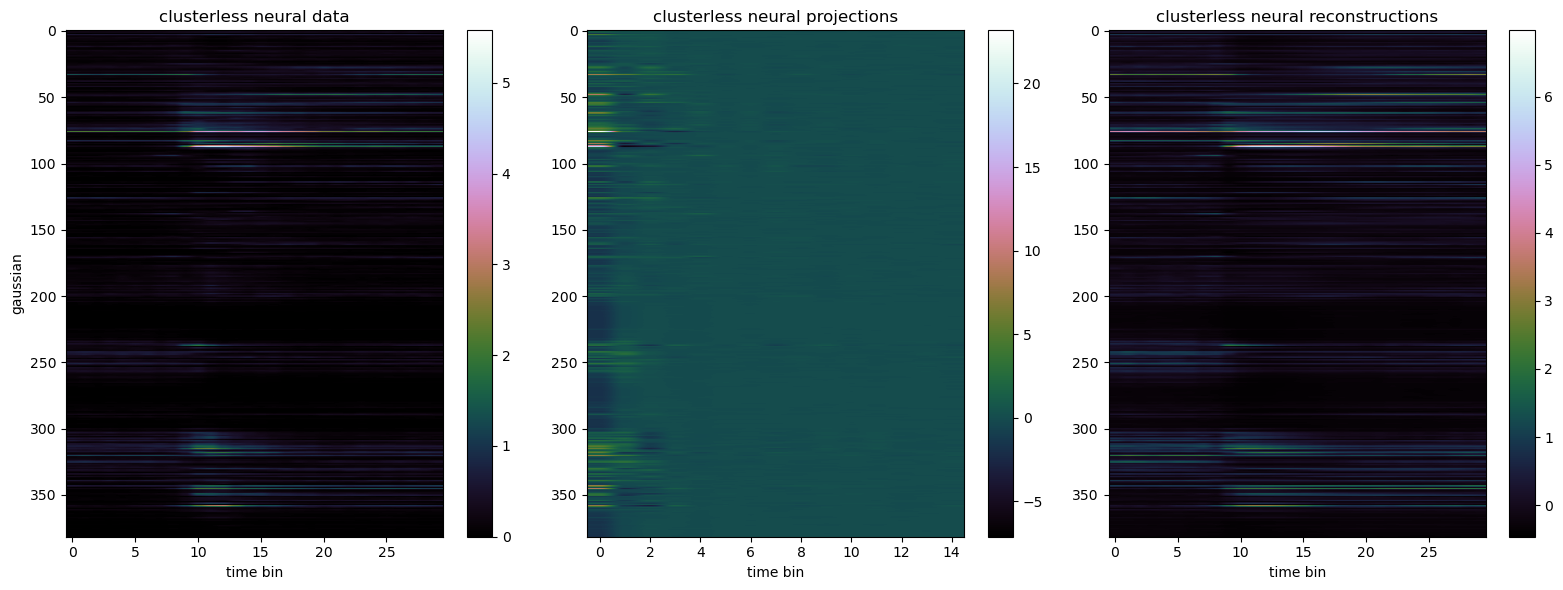

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [13]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.935 auc: 1.000
choice fold 2 test accuracy: 0.957 auc: 0.996
choice fold 3 test accuracy: 0.826 auc: 0.946
choice fold 4 test accuracy: 0.978 auc: 0.997
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.935 auc: 0.988
choice sd of 5-fold cv accuracy: 0.057 auc: 0.021
stimulus fold 1 test accuracy: 0.261 auc: 0.794
stimulus fold 2 test accuracy: 0.348 auc: 0.820
only one class present in y_true, auc score is not defined in that case.
stimulus fold 3 test accuracy: 0.174 auc: nan
stimulus fold 4 test accuracy: 0.174 auc: 0.800
stimulus fold 5 test accuracy: 0.391 auc: 0.857
stimulus mean of 5-fold cv accuracy: 0.270 auc: 0.818
stimulus sd of 5-fold cv accuracy: 0.089 auc: 0.025


split

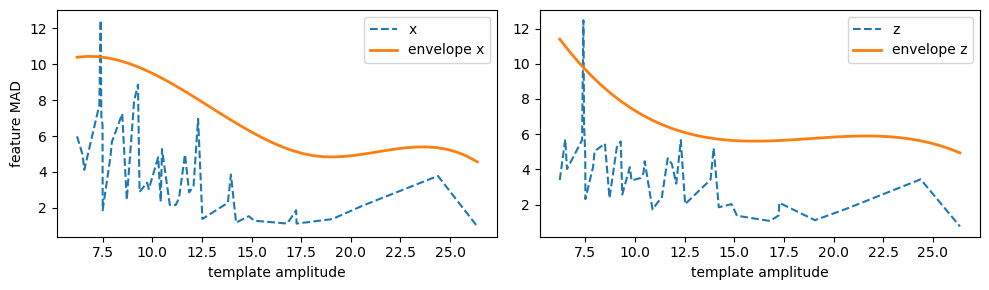

In [14]:
# plot smooth envelope for kilosort template feature MADs

split_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)

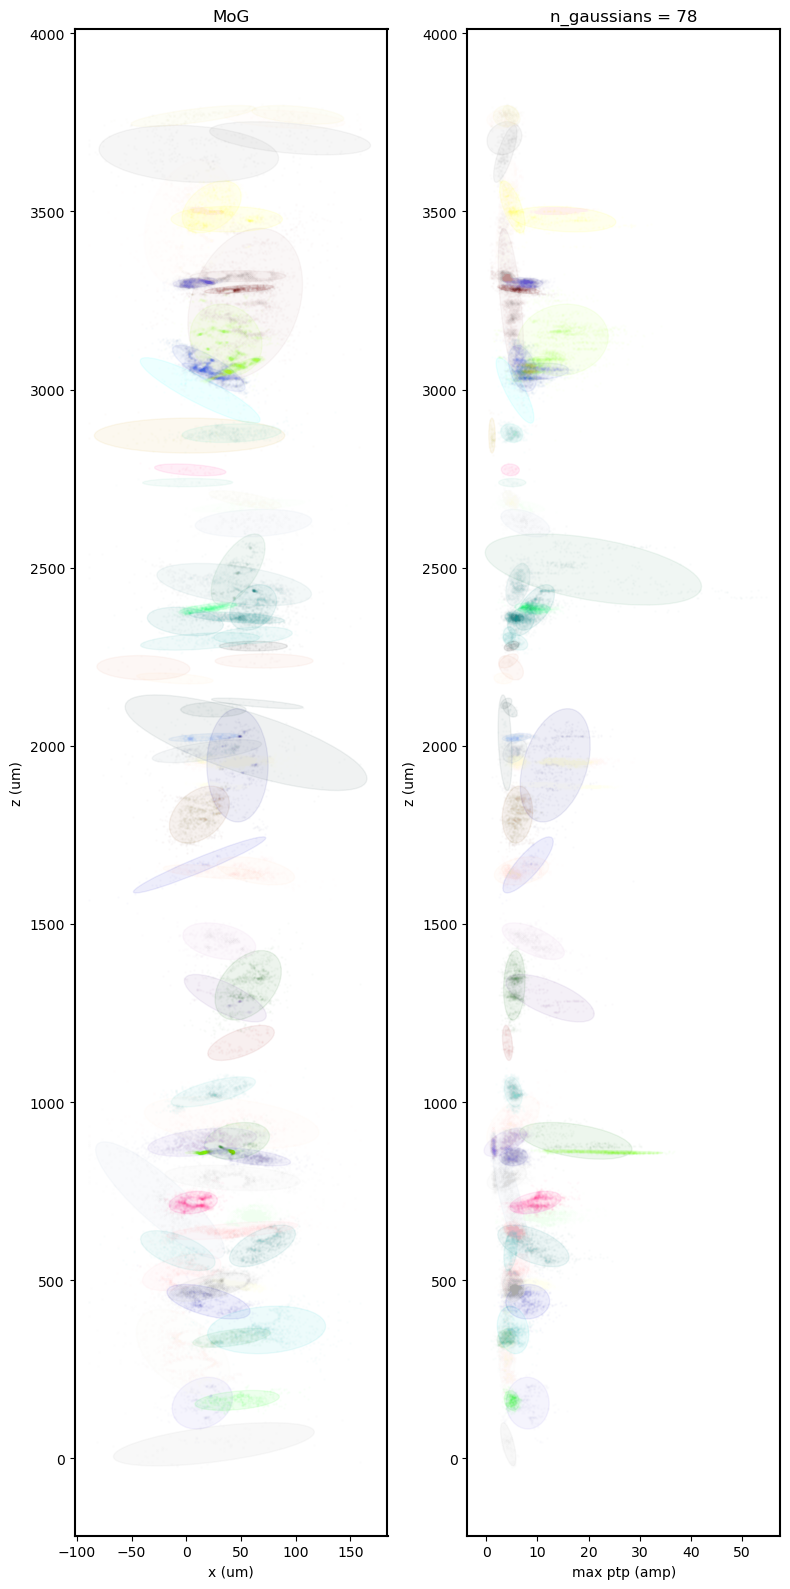

In [15]:
# plot gaussians to be split

viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, split_ids, n_spikes_display=10_000)

In [16]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, fit_model=True)

initial n_gaussians: 384 bic: 14023961.1
keep 304 gaussians and split 78 gaussians ...
pre-split bic: 14914937.72
split gaussian 2 into 2 gaussians with updated bic: 14900670.53
split gaussian 2 into 3 gaussians with updated bic: 14903270.07
split gaussian 13 into 2 gaussians with updated bic: 14865304.93
split gaussian 13 into 3 gaussians with updated bic: 14869804.38
split gaussian 14 into 2 gaussians with updated bic: 14838440.32
split gaussian 14 into 3 gaussians with updated bic: 14843102.11
split gaussian 21 into 2 gaussians with updated bic: 14771507.41
split gaussian 21 into 3 gaussians with updated bic: 14770521.23
split gaussian 21 into 4 gaussians with updated bic: 14769404.53
split gaussian 21 into 5 gaussians with updated bic: 14780210.63
split gaussian 32 into 2 gaussians with updated bic: 14739141.2
split gaussian 32 into 3 gaussians with updated bic: 14742343.34
split gaussian 34 into 2 gaussians with updated bic: 14685659.41
split gaussian 34 into 3 gaussians with upda

In [17]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, fit_model=False)
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

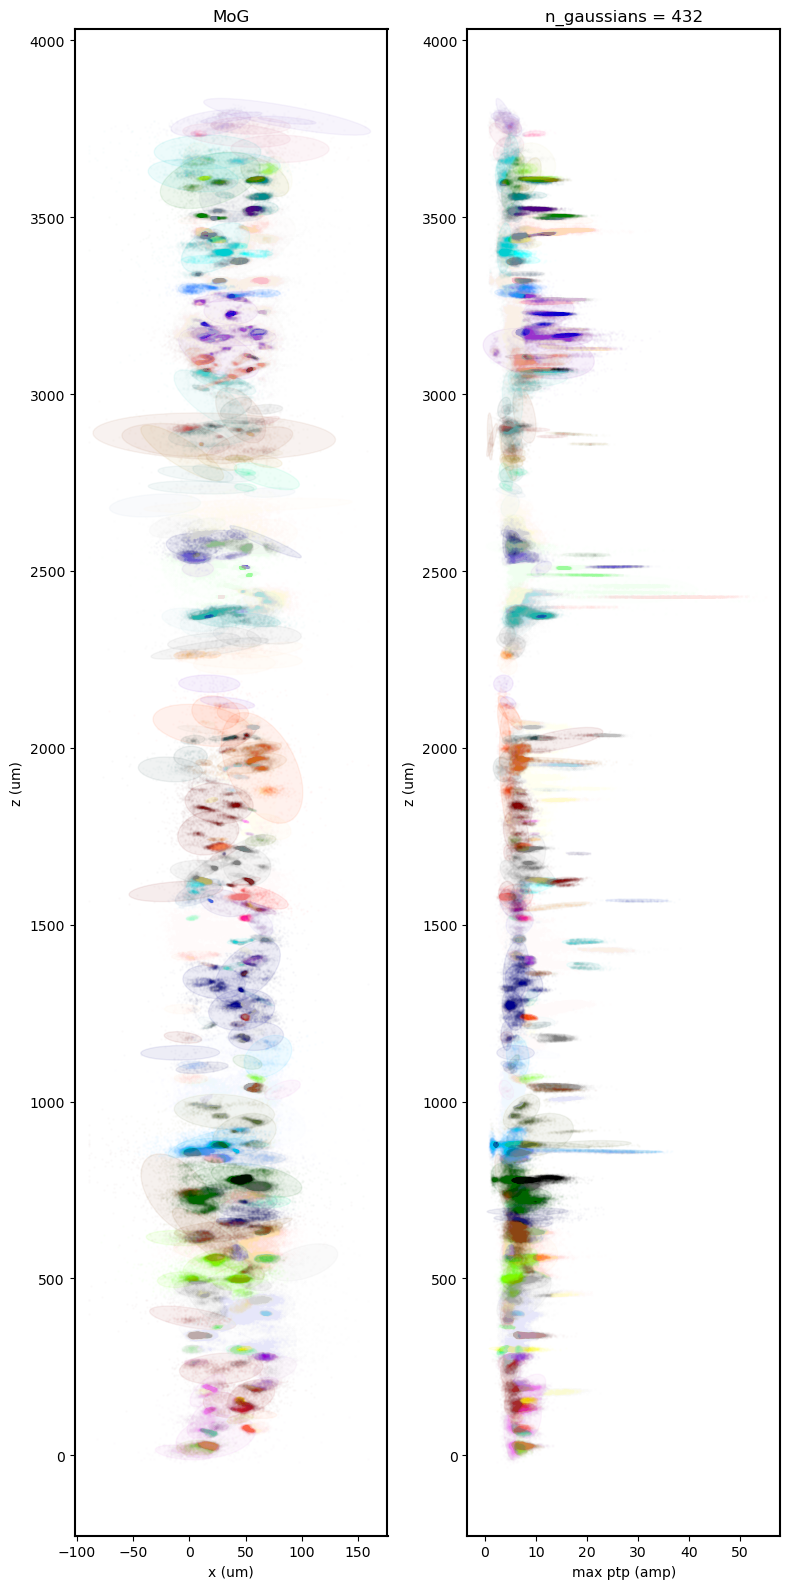

In [18]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, post_split_labels, n_spikes_display=30_000)

merge

In [ ]:
corr_mat = split_merge.calc_corr_matrix(post_split_probs)
# np.save(f'pretrained/{sub_id}/corr_mat.npy', corr_mat)
# corr_mat = np.load(f'pretrained/{sub_id}/corr_mat.npy')

In [ ]:
np.save(f'pretrained/{sub_id}/corr_mat.npy', corr_mat)

In [ ]:
plt.imshow(corr_mat, cmap='Blues', aspect='auto')
plt.xlabel('gaussians')
plt.ylabel('gaussians')
plt.title('correlation matrix')
plt.colorbar();

In [ ]:
merge_ids = split_merge.merge_criteria(corr_mat, 0.55)

In [ ]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, np.unique(merge_ids), n_spikes_display=30_000)

In [ ]:
post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm, post_split_labels, merge_ids, fit_model=True)

In [ ]:
post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm, post_split_labels, merge_ids, fit_model=False)

In [ ]:
post_merge_labels = post_merge_gmm.predict(structured_unsorted)
post_merge_probs = post_merge_gmm.predict_proba(structured_unsorted)

In [ ]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_merge_labels, post_merge_labels, n_spikes_display=30_000)